## Prerequisites

In order to run these examples, it is recommended to use gcc as the default compiler, with OpenMP installed.

Numba and Cython can be installed easily with conda:
#### conda install numba
#### conda install cython

The include path of the NumPy C header files might have to be added to the .bashrc (Linux) or .bash_profile (Mac) files to make Numba run:

In [1]:
import numpy as np
print "export CFLAGS=\"-I",np.__path__[0]+'/core/include/ $CFLAGS\"'

export CFLAGS="-I /home/ghajdu/bin/miniconda2/lib/python2.7/site-packages/numpy/core/include/ $CFLAGS"


Append the output of the print command above
to the .bashrc (Linux) or .bash_profile (Mac) file in the default user library, if Numba does not work out of the box.

# Faster computations in Python

Python's dynamically typed nature makes it easy to quickly write code
that works, however, this comes at the cost of execution speed, as
each time an operation is executed on a variable, its type has to be
checked by the interpreter, in order to execute the appropriate subroutine
for the given combination of variable type and operation.

The speed of computations can be greatly increased by utilizing NumPy,
where the data are stored in homogeneous C arrays inside array objects.
NumPy also provides specialized commands to do calculations quickly on
these arrays.

In this example, we will compare different implementations of a truncated
Fourier sum, which is calculated for a number of different positions.
In astronomical situations, these positions can be, for example, times of
measurement of the magnitude of a star. The sum has the form:

### $m_i (t_i) = \sum_{j=1}^{n} A_j \cdot \sin( 2 \cdot \pi \cdot f_j \cdot t_i +\phi_j )$,

where $m_i$ is the $i$th magnitude of the star at time $t_i$, $n$ is the
number of Fourier terms, $A_j$ is the amplitude, $f_j$ is the frequency, and $\phi_j$ is the phase
of the $j$th Fourier term.

### Preparation

First, we import the packages that we will be using, and prepare the data.
We store the $t_i$, $A_j$, $f_j$ and $\phi_j$ parameters in NumPy arrays.

We also define two functions, one which does the above sum using two for cycles,
and another one exploiting array operations of NumPy.

Furthermore, we prepare for the usage of Cython within the Notebook by loading
the Cython magic commands into it.

In [2]:
import numpy as np
from numba import jit, autojit
%load_ext Cython


times=np.arange(0,70,0.01)
print "The size of the time array:", times.size

freq = np.arange(0.1,6.0,0.1)*1.7763123
freq[-20:] = freq[:20]*0.744
amp  = 0.05/(freq**2)+0.01
phi  = freq

def fourier_sum_naive(times, freq, amp, phi):
    mags = np.zeros_like(times)
    for i in xrange(times.size):
        for j in xrange(freq.size):
            mags[i] += amp[j] * np.sin( 2 * np.pi * freq[j] * times[i] + phi[j] )
            
    return mags
    
def fourier_sum_numpy(times, freq, amp, phi):
    return np.sum(amp.T.reshape(-1,1) * np.sin( 2 * np.pi * freq.T.reshape(-1,1) * times.reshape(1,-1) + phi.T.reshape(-1,1)), axis=0)


The size of the time array: 7000


### Numba

We use the autojit function from Numba to prepare the translation of the Python function to machine code.
By default usage, the functions get translated during runtime (in a Just-In-Time JIT manner), when the
first call is made to the function. Numba produces optimized machine code, taking into account the type of
input the function receives when called for the first time.

Alternatively, the function can be defined like normal, but preceded by the @jit decorator, in order to
notify Numba about the functions to optimize, as show in the commented area below.

Note that Numba can be called eagerly, telling it the type of the expected variable, as well as the return
type of the function. This can be used to fine-tune the behavior of the function. See more in the Numba
documentation:
http://numba.pydata.org/numba-doc/dev/user/jit.html

Note that functions can also be compiled ahead of time. For more information, see:
http://numba.pydata.org/numba-doc/0.32.0/reference/aot-compilation.html

In [3]:
fourier_sum_naive_numba = autojit(fourier_sum_naive)
fourier_sum_numpy_numba = autojit(fourier_sum_numpy)

#@jit
#def fourier_sum_naive_numba(times, freq, amp, phi):
#    mags = np.zeros_like(times)
#    for i in xrange(times.size):
#        for j in xrange(freq.size):
#            mags[i] += amp[j] * np.sin( 2 * np.pi * freq[j] * times[i] + phi[j] )
#            
#    return mags

#@jit()
#def fourier_sum_numpy_numba(times, freq, amp, phi):
#    return np.sum(amp.T.reshape(-1,1) * np.sin( 2 * np.pi * freq.T.reshape(-1,1) * times.reshape(1,-1) + phi.T.reshape(-1,1)), axis=0)


### Cython

Cython works different than Numba: It produces C code that gets compiled before calling the function.
NumPy arrays store the data internally in simple C arrays, which can be accessed with the
Typed Memoryview feature of Cython. This allows operations on these arrays that completely bypass Python.
We can also import C functions, as we could writing pure C by importing the corresponding header files.

In the example implementation of the Fourier sum below, we use define two funtions.
The first one handles interactions with Python, while the second one handles the actual calculations.
Note that we also pass a temp array, in order to provide a reserved space for the function to work
on, eliminating the need to create a NumPy array within the function.

#### Important note
Normal usage of Cython involves creating a separate .pyx file, with the corresponding Cython code inside,
which then gets translated into a source object (.so on Unix-like systems, .dll on Windows), which can
be imported into Python like a normal .py file. See the Cython documentation for more information:
http://docs.cython.org/en/latest/src/quickstart/build.html

In [4]:
%%cython -a

cimport cython
import numpy as np
from libc.math cimport sin, M_PI

def fourier_sum_cython(times, freq, amp, phi, temp):
    return np.asarray(fourier_sum_purec(times, freq, amp, phi, temp))

@cython.boundscheck(False)
@cython.wraparound(False)
cdef fourier_sum_purec(double[:] times, double[:] freq, double[:] amp, double[:] phi, double[:] temp):
    cdef int i, j, irange, jrange
    irange=len(times)
    jrange=len(freq)
    for i in xrange(irange):
        temp[i]=0
        for j in xrange(jrange):
            temp[i] += amp[j] * sin( 2 * M_PI * freq[j] * times[i] + phi[j] )
    return temp

We called the cython command with the -a argument, that makes it produce an html summary of the translated code.
White parts show code that don't interact with Python at all. Optimizing Cython involves minimizing the code
that is "yellow", making the code "whiter", that is, executing more code in C.

#### Cython + OpenMP

We can parallelize the execution of the code using OpenMP in the parts where the code is executed
completely outside of Python, but we need to release the Global Interpreter Lock (GIL) first.
The prange command replaces the range or xrange command in the for cycle we would like to execute in
parallel. We can also call OpenMP functions, for example, to get the number of processor cores of the
system.

Note that the number of threads, the scheduler and the chunksize can have a large effect on the
performance of the code. While optimizing, you should try different chunksizes (the default is 1).

In [5]:
%%cython --compile-args=-fopenmp --link-args=-fopenmp --force -a

cimport cython
cimport openmp
import numpy as np
from libc.math cimport sin, M_PI
from cython.parallel import parallel, prange

def fourier_sum_cython_omp(times, freq, amp, phi, temp):
    return np.asarray(fourier_sum_purec_omp(times, freq, amp, phi, temp))

@cython.boundscheck(False)
@cython.wraparound(False)
cdef fourier_sum_purec_omp(double[:] times, double[:] freq, double[:] amp, double[:] phi, double[:] temp):
    cdef int i, j, irange, jrange
    irange=len(times)
    jrange=len(freq)
    #print openmp.omp_get_num_procs()
    with nogil, parallel(num_threads=4):
        for i in prange(irange, schedule='dynamic', chunksize=10):
            temp[i]=0
            for j in xrange(jrange):
                temp[i] += amp[j] * sin( 2 * M_PI * freq[j] * times[i] + phi[j] )
    return temp   

### Comparison

Finally, we compare the execution times of the implementations of the funtions.

In [6]:
temp=np.zeros_like(times)

amps_naive      = fourier_sum_naive(times, freq, amp, phi)
amps_numpy      = fourier_sum_numpy(times, freq, amp, phi)
amps_numba1     = fourier_sum_naive_numba(times, freq, amp, phi)
amps_numba2     = fourier_sum_numpy_numba(times, freq, amp, phi)
amps_cython     = fourier_sum_cython(times, freq, amp, phi, temp)
amps_cython_omp = fourier_sum_cython_omp(times, freq, amp, phi, temp)

%timeit -n 5  -r 5  fourier_sum_naive(times, freq, amp, phi)
%timeit -n 10 -r 10 fourier_sum_numpy(times, freq, amp, phi)
%timeit -n 10 -r 10 fourier_sum_naive_numba(times, freq, amp, phi)
%timeit -n 10 -r 10 fourier_sum_numpy_numba(times, freq, amp, phi)
%timeit -n 10 -r 10 fourier_sum_cython(times, freq, amp, phi, temp)
%timeit -n 10 -r 10 fourier_sum_cython_omp(times, freq, amp, phi, temp)



5 loops, best of 5: 887 ms per loop
10 loops, best of 10: 20.1 ms per loop
10 loops, best of 10: 19 ms per loop
10 loops, best of 10: 20 ms per loop
10 loops, best of 10: 19.3 ms per loop
10 loops, best of 10: 9.35 ms per loop


[ 0.  0.  0. ...,  0.  0.  0.]


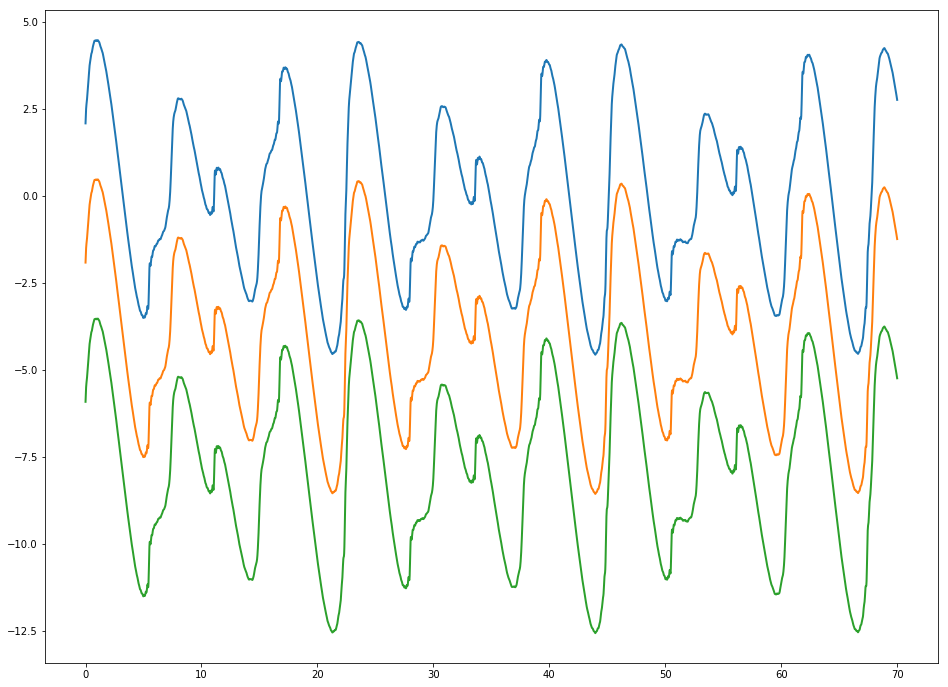

In [7]:
import matplotlib.pylab as plt

print amps_numpy-amps_cython

fig=plt.figure()
fig.set_size_inches(16,12)

plt.plot(times,amps_naive         ,'-', lw=2.0)
#plt.plot(times,amps_numpy      - 2,'-', lw=2.0)
plt.plot(times,amps_numba1     - 4,'-', lw=2.0)
#plt.plot(times,amps_numba2     - 6,'-', lw=2.0)
plt.plot(times,amps_cython     - 8,'-', lw=2.0)
#plt.plot(times,amps_cython_omp -10,'-', lw=2.0)

plt.show()